In [10]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
sys.path.append('../src')
import utils
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings('ignore')
# import dimension_clustering

plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def load_dimension_words(file_path):
    """
    加载维度词表文件
    
    Args:
        file_path: 维度词表文件路径
        
    Returns:
        dict: 维度名称到词列表的映射
    """
    dimensions = {}
    current_dimension = None
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                    
                if line.endswith(':'):
                    current_dimension = line[:-1]
                    dimensions[current_dimension] = []
                elif current_dimension:
                    words = line.split()
                    dimensions[current_dimension].extend(words)
                    
        return dimensions
    except Exception as e:
        print(f"加载维度词表时出错: {e}")
        return {}


def cluster_similar_words(models, similar_words_by_period, n_clusters=4, 
                         exclude_words_path=None, top_n=150):
    """
    对相似词进行聚类分析，为每个时期的模型都执行聚类
    
    Args:
        models: 词向量模型字典
        similar_words_by_period: 各时期相似词字典
        n_clusters: 聚类数量
        exclude_words_path: 排除词文件路径
        top_n: 每个时期取前N个词
        
    Returns:
        dict: 每个时期的聚类结果 {period: (clusters, word_vectors, cluster_labels, valid_words)}
    """
    # 加载排除词
    exclude_words = set()
    if exclude_words_path and Path(exclude_words_path).exists():
        exclude_words = utils.load_exclude_words(exclude_words_path)
        print(f"已加载 {len(exclude_words)} 个排除词")
    
    # 获取所有时期的词汇并集
    all_words = set()
    for period, word_list in similar_words_by_period.items():
        # 过滤排除词并取前N个
        filtered_words = [(word, sim) for word, sim in word_list 
                         if word not in exclude_words][:top_n]
        period_words = set(word for word, _ in filtered_words)
        all_words.update(period_words)
    
    print(f"总共收集到 {len(all_words)} 个唯一词汇")
    
    # 为每个时期的模型执行聚类
    all_results = {}
    
    for period, model in models.items():
        print(f"\n=== 对 {period} 模型进行聚类 ===")
        
        # 提取在当前模型中存在的词及其向量
        valid_words = []
        word_vectors = []
        
        for word in all_words:
            if word in model:
                valid_words.append(word)
                word_vectors.append(model[word])
        
        if not word_vectors:
            print(f"{period}: 没有找到有效的词向量")
            all_results[period] = ({}, np.array([]), [], [])
            continue
        
        word_vectors = np.array(word_vectors)
        print(f"{period}: 成功提取 {len(valid_words)} 个词的向量，维度: {word_vectors.shape}")
        
        # 执行K-means聚类
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(word_vectors)
        
        # 整理聚类结果
        clusters = {}
        for i in range(n_clusters):
            cluster_words = [valid_words[j] for j in range(len(valid_words)) 
                            if cluster_labels[j] == i]
            clusters[f"聚类{i+1}"] = cluster_words
            print(f"  聚类{i+1}: {len(cluster_words)} 个词")
            print(f"    前10个词: {cluster_words[:10]}")
        
        # 保存当前时期的结果
        all_results[period] = (clusters, word_vectors, cluster_labels, valid_words)
        
        # 保存聚类结果到文件
        save_cluster_results(clusters, f"topic_word/cluster_results_{period}_{n_clusters}.txt")
    
    return all_results

def visualize_clusters(word_vectors, cluster_labels, valid_words, method='tsne', 
                      max_labels=50):
    """
    可视化聚类结果
    
    Args:
        word_vectors: 词向量矩阵
        cluster_labels: 聚类标签
        valid_words: 词列表
        method: 降维方法 ('tsne' 或 'pca')
        max_labels: 最大显示标签数
    """
    if len(word_vectors) == 0:
        print("没有数据可以可视化")
        return
    
    # 降维
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(word_vectors)-1))
    else:
        reducer = PCA(n_components=2, random_state=42)
    
    reduced_vectors = reducer.fit_transform(word_vectors)
    
    # 绘图
    plt.figure(figsize=(14, 10))
    
    # 为每个聚类使用不同颜色
    unique_labels = np.unique(cluster_labels)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = cluster_labels == label
        plt.scatter(reduced_vectors[mask, 0], reduced_vectors[mask, 1], 
                   c=[colors[i]], label=f'聚类{label+1}', alpha=0.7, s=50)
    
    # 添加词标签（只显示部分以避免重叠）
    if len(valid_words) <= max_labels:
        for i, word in enumerate(valid_words):
            plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]), 
                        fontsize=8, alpha=0.8)
    else:
        # 随机选择一些词显示标签
        indices = np.random.choice(len(valid_words), max_labels, replace=False)
        for i in indices:
            plt.annotate(valid_words[i], 
                        (reduced_vectors[i, 0], reduced_vectors[i, 1]), 
                        fontsize=8, alpha=0.8)
    
    plt.title(f'法治相关词汇聚类可视化 ({method.upper()})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return plt.gcf()

def analyze_cluster_quality(word_vectors, cluster_labels):
    """分析聚类质量"""
    if len(set(cluster_labels)) > 1:
        silhouette = silhouette_score(word_vectors, cluster_labels)
        calinski = calinski_harabasz_score(word_vectors, cluster_labels)
        
        print(f"轮廓系数 (Silhouette Score): {silhouette:.3f}")
        print(f"Calinski-Harabasz指数: {calinski:.3f}")
        
        return silhouette, calinski
    else:
        print("只有一个聚类，无法计算质量指标")
        return None, None

def save_cluster_results(clusters, output_path):
    """保存聚类结果到文件"""
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write("# 法治相关词汇聚类结果\n\n")
        
        for cluster_name, words in clusters.items():
            f.write(f"# {cluster_name} ({len(words)}个词)\n")
            f.write(f"{cluster_name}:\n")
            
            # 每行写10个词
            for i in range(0, len(words), 10):
                line_words = words[i:i+10]
                f.write(" ".join(line_words) + "\n")
            f.write("\n")
    
    print(f"已保存聚类结果到: {output_path}")

def calculate_dimension_similarities(models, dimension_words, target_word="法治", normalize=True):
    """
    计算目标词与各维度的相似度
    
    Args:
        models: 词向量模型字典
        dimension_words: 维度词表字典
        target_word: 目标词
        normalize: 是否归一化相似度
        
    Returns:
        DataFrame: 各时期各维度的相似度矩阵
    """
    periods = sorted(models.keys())
    dimensions = list(dimension_words.keys())
    
    # 创建结果DataFrame
    similarity_data = []
    
    for period in periods:
        model = models[period]
        if target_word not in model:
            print(f"警告: '{target_word}'在{period}模型中不存在")
            continue
            
        period_similarities = {"时期": period}
        
        for dim in dimensions:
            dim_words = dimension_words[dim]
            similarities = []
            
            for word in dim_words:
                if word in model and word != target_word:
                    try:
                        sim = model.similarity(target_word, word)
                        similarities.append(sim)
                    except:
                        pass
            
            if similarities:
                avg_sim = np.mean(similarities)
                period_similarities[dim] = avg_sim
            else:
                period_similarities[dim] = 0

        if normalize:
            # 确保各维度相似度之和为1
            # 只对维度相似度进行归一化，排除"时期"字段
            dim_similarities = {k: v for k, v in period_similarities.items() if k != "时期"}
            total_sim = sum(dim_similarities.values())
            if total_sim > 0:
                for dim in dimensions:
                    period_similarities[dim] = period_similarities[dim] / total_sim
 
        similarity_data.append(period_similarities)
    
    return pd.DataFrame(similarity_data)

def plot_dimension_trends(similarity_df, title="法治维度语义相似度变化趋势"):
    """绘制维度趋势图"""
    plt.figure(figsize=(12, 6))
    
    periods = similarity_df["时期"]
    dimensions = [col for col in similarity_df.columns if col != "时期"]
    
    for dim in dimensions:
        plt.plot(periods, similarity_df[dim], marker='o', linewidth=2, label=dim)
    
    plt.title(title)
    plt.xlabel("时期")
    plt.ylabel("平均相似度")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return plt.gcf()

def plot_dimension_radar(similarity_df, title="法治维度语义结构雷达图"):
    """绘制雷达图"""
    periods = similarity_df["时期"].tolist()
    dimensions = [col for col in similarity_df.columns if col != "时期"]
    N = len(dimensions)
    
    # 设置角度
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # 闭合雷达图
    
    # 创建图形
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
    
    # 为每个时期绘制一条线
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for i, period in enumerate(periods):
        values = similarity_df.iloc[i][dimensions].tolist()
        values += values[:1]  # 闭合雷达图
        
        # 绘制线条
        ax.plot(angles, values, linewidth=2, label=period, color=colors[i % len(colors)])
        # 填充区域
        ax.fill(angles, values, alpha=0.1, color=colors[i % len(colors)])
    
    # 设置标签
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(dimensions)
    
    # 添加图例和标题
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.title(title, size=15, pad=20)
    plt.show()
    
    return fig

def plot_dimension_heatmap(similarity_df, title="法治维度语义相似度热力图"):
    """绘制热力图"""
    # 准备数据
    periods = similarity_df["时期"].tolist()
    dimensions = [col for col in similarity_df.columns if col != "时期"]
    
    # 创建矩阵
    matrix_data = similarity_df[dimensions].values
    
    # 绘制热力图
    plt.figure(figsize=(10, 6))
    sns.heatmap(matrix_data, 
                xticklabels=dimensions, 
                yticklabels=periods,
                annot=True, 
                fmt='.3f', 
                cmap="YlOrRd", 
                linewidths=0.5)
    
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    return plt.gcf()


In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from gensim.models import KeyedVectors
import matplotlib.font_manager as fm
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import sys
from pathlib import Path


# 设置更好的可视化风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
# 假设notebooks目录在项目根目录下
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from src.utils import download_chinese_font
import src.utils as utils
# 下载并安装字体
font_path = download_chinese_font()

# 设置matplotlib使用下载的字体
if font_path:
    plt.rcParams['font.sans-serif'] = ['SimHei'] + plt.rcParams['font.sans-serif']
    print("成功设置中文字体")
else:
    print("无法设置中文字体，将使用替代方案")

plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


# 测试中文显示
# plt.figure(figsize=(6, 4))
# plt.title("中文测试")
# plt.text(0.5, 0.5, "法治", fontsize=20, ha='center')
# plt.axis('off')
# plt.show()

# 定义项目根目录和模型目录
PROJECT_ROOT = Path.cwd().parent
MODELS_DIR = PROJECT_ROOT / "models"

# 可能的模型目录
FINE_TUNED_MODELS_DIR = MODELS_DIR / "fine_tuned_vectors_flexible"
SLIDING_WINDOW_MODELS_DIR = MODELS_DIR / "fine_tuned_vectors_sliding_window"

# 检查哪个目录存在并包含模型
if FINE_TUNED_MODELS_DIR.exists() and any(FINE_TUNED_MODELS_DIR.glob("*_wordvectors.kv")):
    MODELS_DIR = FINE_TUNED_MODELS_DIR
    print(f"使用固定时期模型目录: {MODELS_DIR}")
elif SLIDING_WINDOW_MODELS_DIR.exists():
    # 查找滑动窗口模型的子目录
    subdirs = [d for d in SLIDING_WINDOW_MODELS_DIR.iterdir() if d.is_dir()]
    if subdirs:
        MODELS_DIR = subdirs[0]  # 使用第一个子目录
        print(f"使用滑动窗口模型目录: {MODELS_DIR}")
    else:
        print(f"滑动窗口模型目录存在，但没有子目录")
else:
    print(f"未找到模型目录，使用默认路径: {MODELS_DIR}")

# 加载所有可用的模型
def load_models():
    """加载目录中所有的词向量模型"""
    models = {}
    model_files = list(MODELS_DIR.glob("*_wordvectors.kv"))
    
    if not model_files:
        print(f"在 {MODELS_DIR} 中没有找到模型文件")
        return models
    
    print(f"找到 {len(model_files)} 个模型文件:")
    for model_file in sorted(model_files):
        period_name = model_file.stem.replace("_wordvectors", "")
        print(f"  加载模型: {period_name}")
        try:
            models[period_name] = KeyedVectors.load(str(model_file))
            print(f"  成功加载 {period_name}, 词汇量: {len(models[period_name].index_to_key)}")
        except Exception as e:
            print(f"  加载 {period_name} 失败: {e}")
    
    return models

# 加载模型
models = load_models()

# 检查模型是否成功加载
if not models:
    print("没有成功加载任何模型，请检查模型路径")
else:
    print(f"\n成功加载了 {len(models)} 个模型:")
    for period_name, model in models.items():
        print(f"  {period_name}: 词汇量 {len(model.index_to_key)}")

字体已存在: /home/fangshikai/.fonts/SimHei.ttf
刷新字体缓存...
成功设置中文字体
使用固定时期模型目录: /home/fangshikai/law-word-vector/models/fine_tuned_vectors_flexible
找到 3 个模型文件:
  加载模型: Era1_1978-1996
  成功加载 Era1_1978-1996, 词汇量: 4874
  加载模型: Era2_1997-2013
  成功加载 Era2_1997-2013, 词汇量: 4992
  加载模型: Era3_2014-2024
  成功加载 Era3_2014-2024, 词汇量: 5000

成功加载了 3 个模型:
  Era1_1978-1996: 词汇量 4874
  Era2_1997-2013: 词汇量 4992
  Era3_2014-2024: 词汇量 5000


In [12]:
# 创建输出目录
topic_word_dir = Path("topic_word")
topic_word_dir.mkdir(exist_ok=True)


era_files = {
    'Era1_1978-1996': 'similar_words/Era1_1978-1996_final.txt',
    'Era2_1997-2013': 'similar_words/Era2_1997-2013_final.txt',
    'Era3_2014-2024': 'similar_words/Era3_2014-2024_final.txt'
}

similar_words_by_period = {}
for era, file_path in era_files.items():
    word_list = utils.load_expert_word_list(file_path)
    if word_list:
        similar_words_by_period[era] = word_list
        print(f"加载 {era}: {len(word_list)} 个词")

    

加载 Era1_1978-1996: 150 个词
加载 Era2_1997-2013: 150 个词
加载 Era3_2014-2024: 150 个词


In [13]:
def cluster_similar_words(models, similar_words_by_period, n_clusters=3, 
                         exclude_words_path=None, top_n=150):
    """
    对相似词进行聚类分析
    
    Args:
        models: 词向量模型字典
        similar_words_by_period: 各时期相似词字典
        n_clusters: 聚类数量
        exclude_words_path: 排除词文件路径
        top_n: 每个时期取前n个词
        
    Returns:
        tuple: (聚类结果字典, 词向量矩阵, 聚类标签, 有效词列表)
    """
    # 获取所有时期的词汇并集
    intersection, union, filtered_similar_words = utils.get_word_sets(
        similar_words_by_period, top_n=top_n, exclude_words_path=exclude_words_path
    )
    
    print(f"聚类分析使用词汇数量: {len(union)}")
    
    # 使用最新时期的模型进行聚类
    latest_period = max(models.keys())
    model = models[latest_period]
    print(f"使用 {latest_period} 模型进行聚类")
    
    # 提取词向量
    valid_words = []
    word_vectors = []
    
    for word in union:
        if word in model:
            valid_words.append(word)
            word_vectors.append(model[word])
    
    if len(valid_words) < n_clusters:
        print(f"有效词汇数量({len(valid_words)})少于聚类数量({n_clusters})")
        return {}, np.array([]), [], []
    
    word_vectors = np.array(word_vectors)
    print(f"有效词汇数量: {len(valid_words)}")
    
    # 执行K-means聚类
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(word_vectors)
    
    # 整理聚类结果
    clusters = {}
    for i in range(n_clusters):
        cluster_words = [valid_words[j] for j in range(len(valid_words)) if cluster_labels[j] == i]
        clusters[f"聚类{i+1}"] = cluster_words
        print(f"聚类{i+1}: {len(cluster_words)} 个词")
        print(f"  前10个词: {cluster_words[:10]}")
    
    return clusters, word_vectors, cluster_labels, valid_words

In [14]:
print("\n=== 执行4聚类分析 ===")
all_results_cluster_4= cluster_similar_words(
    models, similar_words_by_period, n_clusters=4, 
    exclude_words_path="exclude_words.txt", top_n=150
)

# print("\n=== 执行3聚类分析 ===")
# all_results_cluster_3= cluster_similar_words(
#     models, similar_words_by_period, n_clusters=3, 
#     exclude_words_path="exclude_words.txt", top_n=150
# )


=== 执行4聚类分析 ===
已加载 17 个排除词
Era1_1978-1996: 过滤后保留 149 个词
Era2_1997-2013: 过滤后保留 148 个词
Era3_2014-2024: 过滤后保留 148 个词
所有时期共有词: 41 个
所有时期词汇并集: 284 个
聚类分析使用词汇数量: 284
使用 Era3_2014-2024 模型进行聚类
有效词汇数量: 233


聚类1: 45 个词
  前10个词: ['职业道德', '行为习惯', '教育引导', '德治', '道德教育', '法律常识', '自律', '普法教育', '诚信', '法律意识']
聚类2: 26 个词
  前10个词: ['执法不严', '司法权', '法律化', '公信', '人人平等', '崇法', '他律', '重典', '违法不究', '执法必严']
聚类3: 115 个词
  前10个词: ['纪律', '合法权益', '治理体系', '经济体制', '体制', '建设', '体系', '管理', '监督管理', '政治']
聚类4: 47 个词
  前10个词: ['公民权利', '立法法', '法律监督', '司法改革', '民法', '组织法', '民主', '立法', '法治政府', '公正司法']



=== 可视化4聚类结果 ===


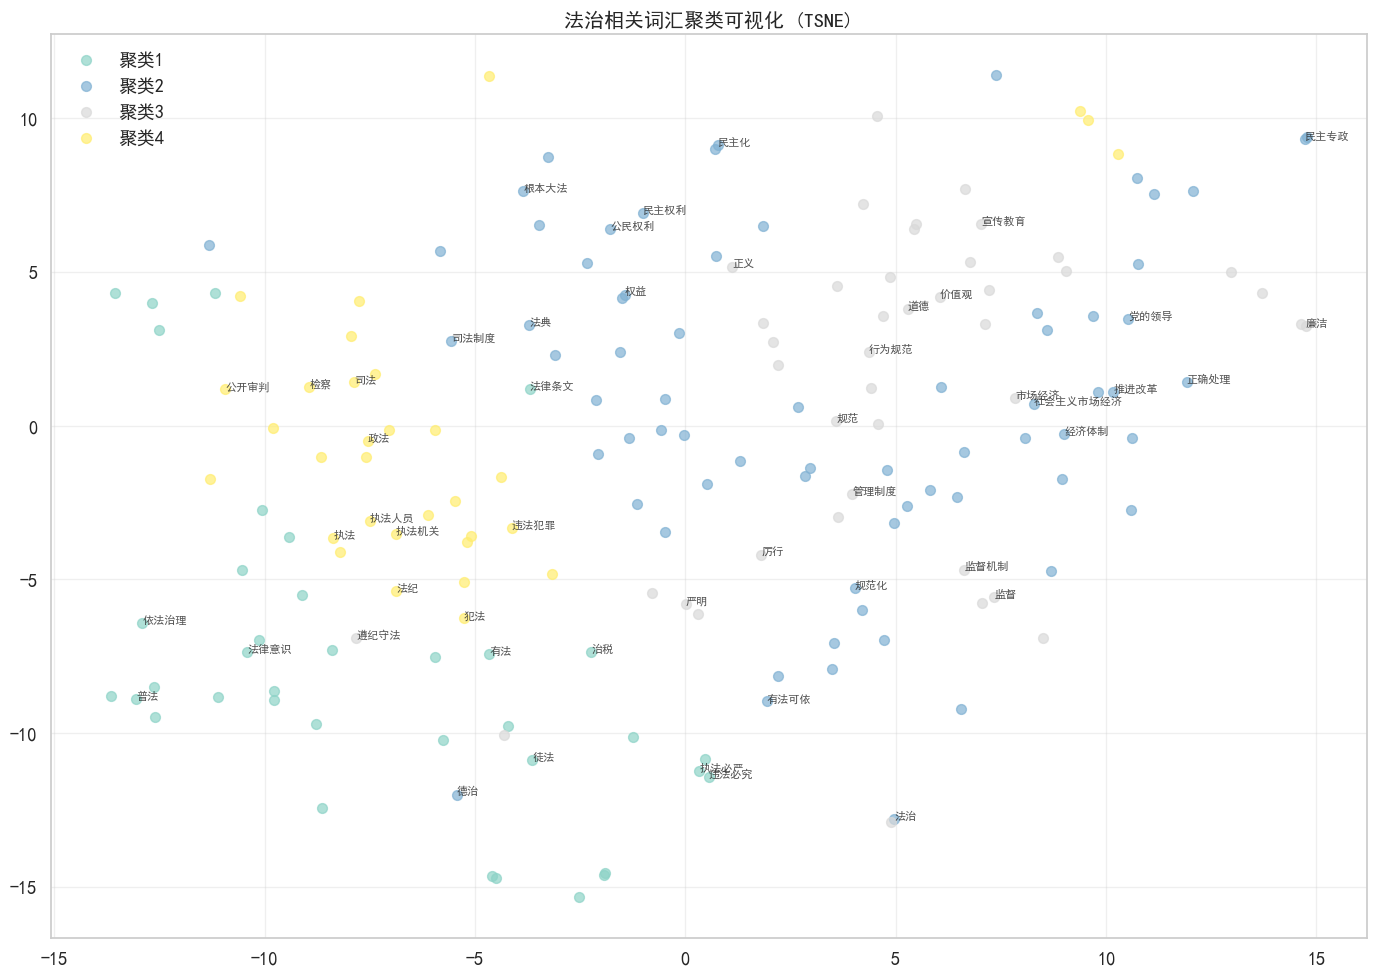


=== 可视化4聚类结果 ===


<Figure size 640x480 with 0 Axes>

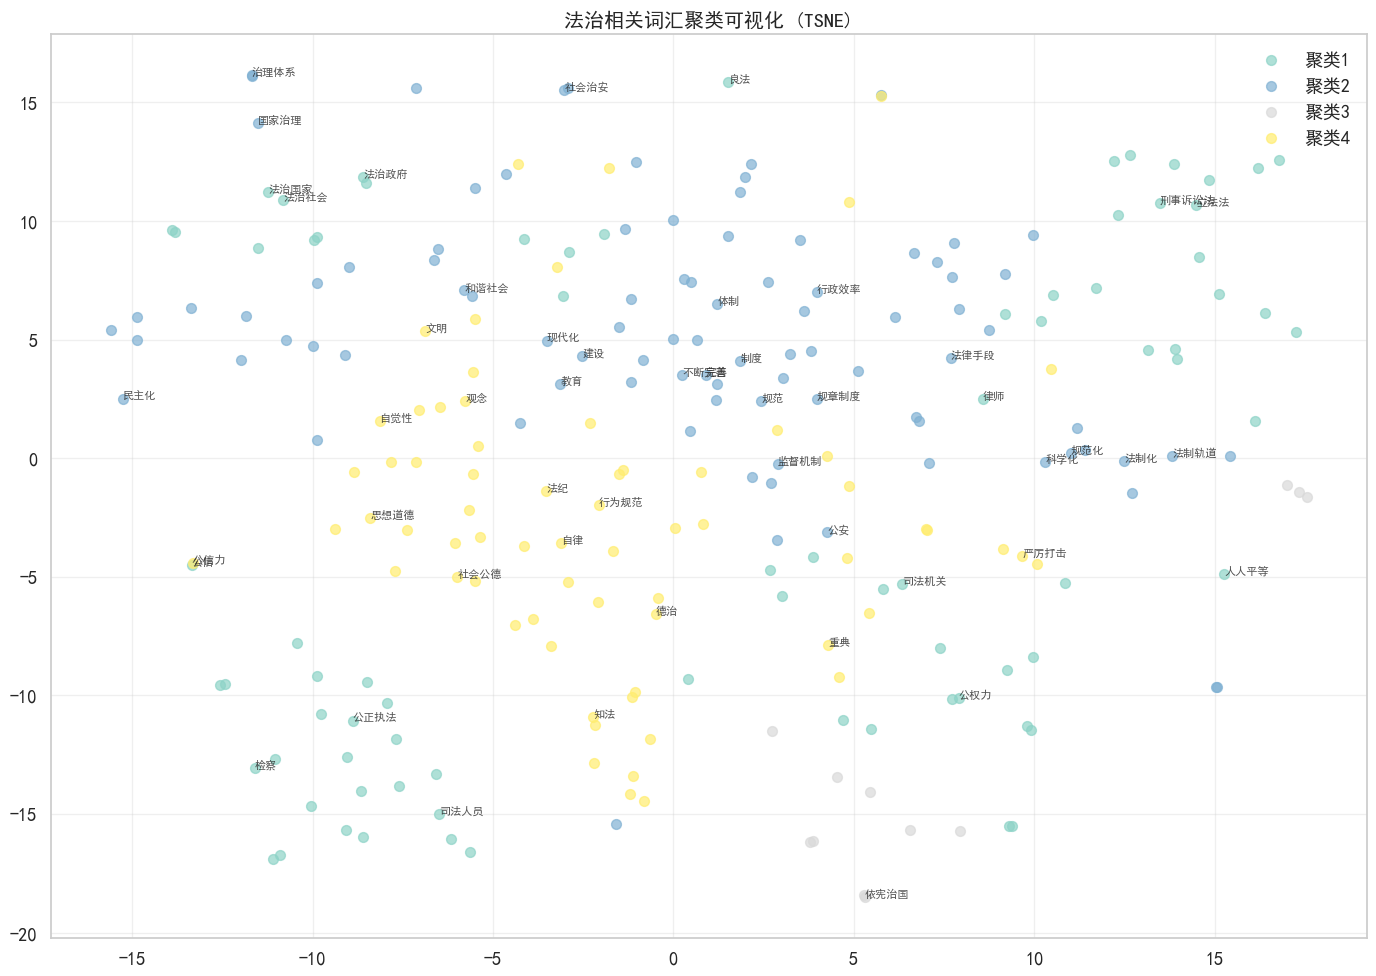


=== 可视化4聚类结果 ===


<Figure size 640x480 with 0 Axes>

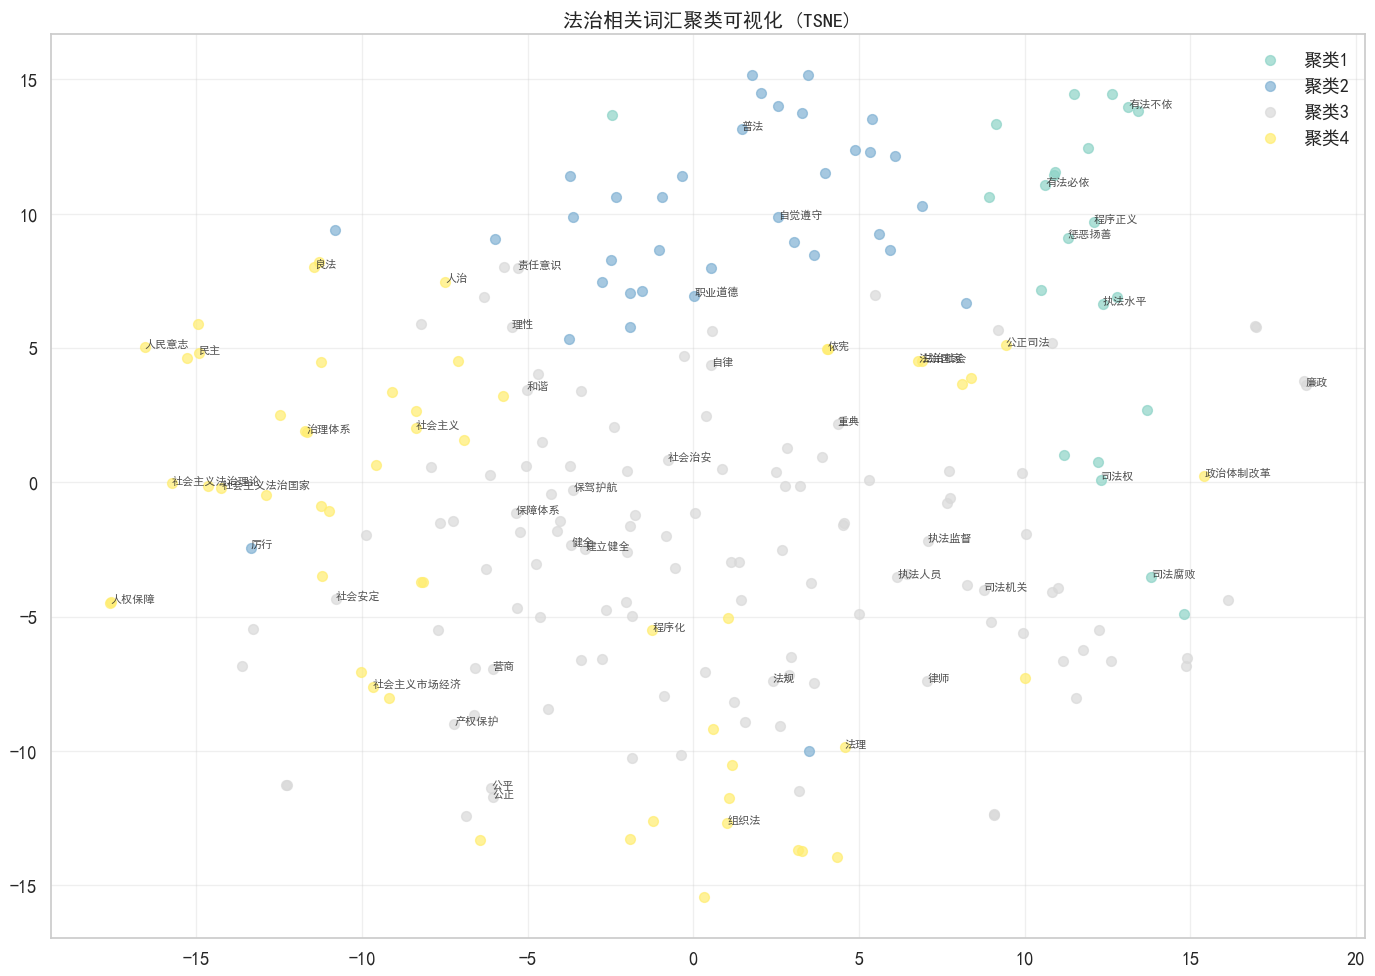

<Figure size 640x480 with 0 Axes>

In [14]:
for period, result in all_results_cluster_4.items():   
    clusters_4,word_vectors_4,cluster_labels_4,valid_words_4=result
    print("\n=== 可视化4聚类结果 ===")
    visualize_clusters(word_vectors_4, cluster_labels_4, valid_words_4, method='tsne')


已加载4维度词表:
  制度建构: 21 个词
  程序正义: 18 个词
  权利保障: 20 个词
  治理效能: 20 个词

4维度相似度矩阵:
               时期      制度建构      程序正义      权利保障      治理效能
0  Era1_1978-1996  0.309728  0.264290  0.207684  0.365729
1  Era2_1997-2013  0.357989  0.382325  0.310768  0.501166
2  Era3_2014-2024  0.360454  0.280954  0.285411  0.449224


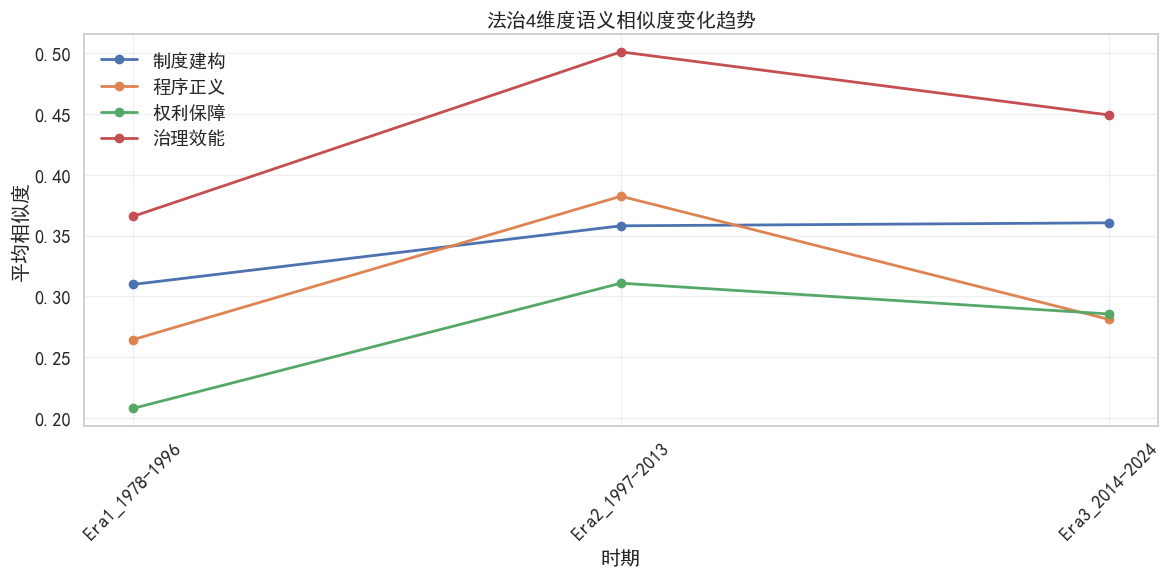

<Figure size 640x480 with 0 Axes>

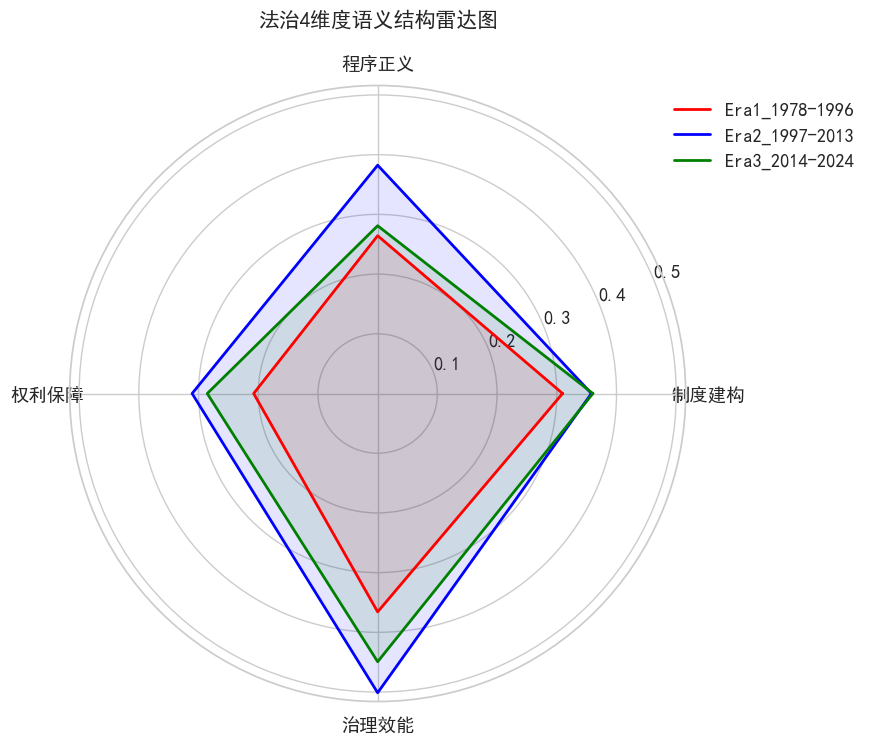

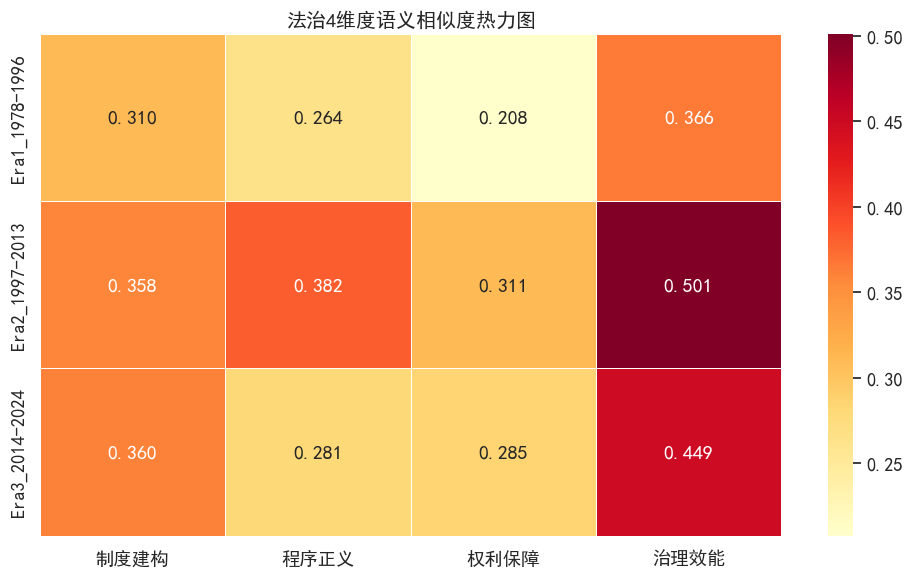

<Figure size 640x480 with 0 Axes>

In [18]:
dimension_words_4d = load_dimension_words(topic_word_dir / "dimension_words_4d.txt")
if dimension_words_4d:
    print("\n已加载4维度词表:")
    for dim, words in dimension_words_4d.items():
        print(f"  {dim}: {len(words)} 个词")
    
    # 计算相似度
    similarity_df_4d = calculate_dimension_similarities(models, dimension_words_4d,target_word="法治",normalize=False)
    print("\n4维度相似度矩阵:")
    print(similarity_df_4d)
    
    # 绘制可视化
    if not similarity_df_4d.empty:
        plot_dimension_trends(similarity_df_4d, "法治4维度语义相似度变化趋势")
        plot_dimension_radar(similarity_df_4d, "法治4维度语义结构雷达图")
        plot_dimension_heatmap(similarity_df_4d, "法治4维度语义相似度热力图")



=== 基于平均相似度扩展4维度词表 ===
使用所有 3 个模型的平均相似度进行词表扩展
候选词数量: 1146

扩展后的词表统计:
制度建构: 80 个词 (原有 21 + 新增 59)
程序正义: 80 个词 (原有 18 + 新增 62)
权利保障: 71 个词 (原有 20 + 新增 51)
治理效能: 80 个词 (原有 20 + 新增 60)
已保存扩展词表到: expanded_dimension_words_4d.txt

4维度相似度矩阵:
               时期      制度建构      程序正义      权利保障      治理效能
0  Era1_1978-1996  0.269932  0.230332  0.180999  0.318738
1  Era2_1997-2013  0.230626  0.246304  0.200205  0.322865
2  Era3_2014-2024  0.261950  0.204175  0.207414  0.326461

=== 扩展后词表相似度分析 ===

扩展后4维度相似度矩阵:
               时期      制度建构      程序正义      权利保障      治理效能
0  Era1_1978-1996  0.263733  0.254010  0.212522  0.269735
1  Era2_1997-2013  0.231653  0.248102  0.233302  0.286943
2  Era3_2014-2024  0.257287  0.238991  0.223543  0.280179


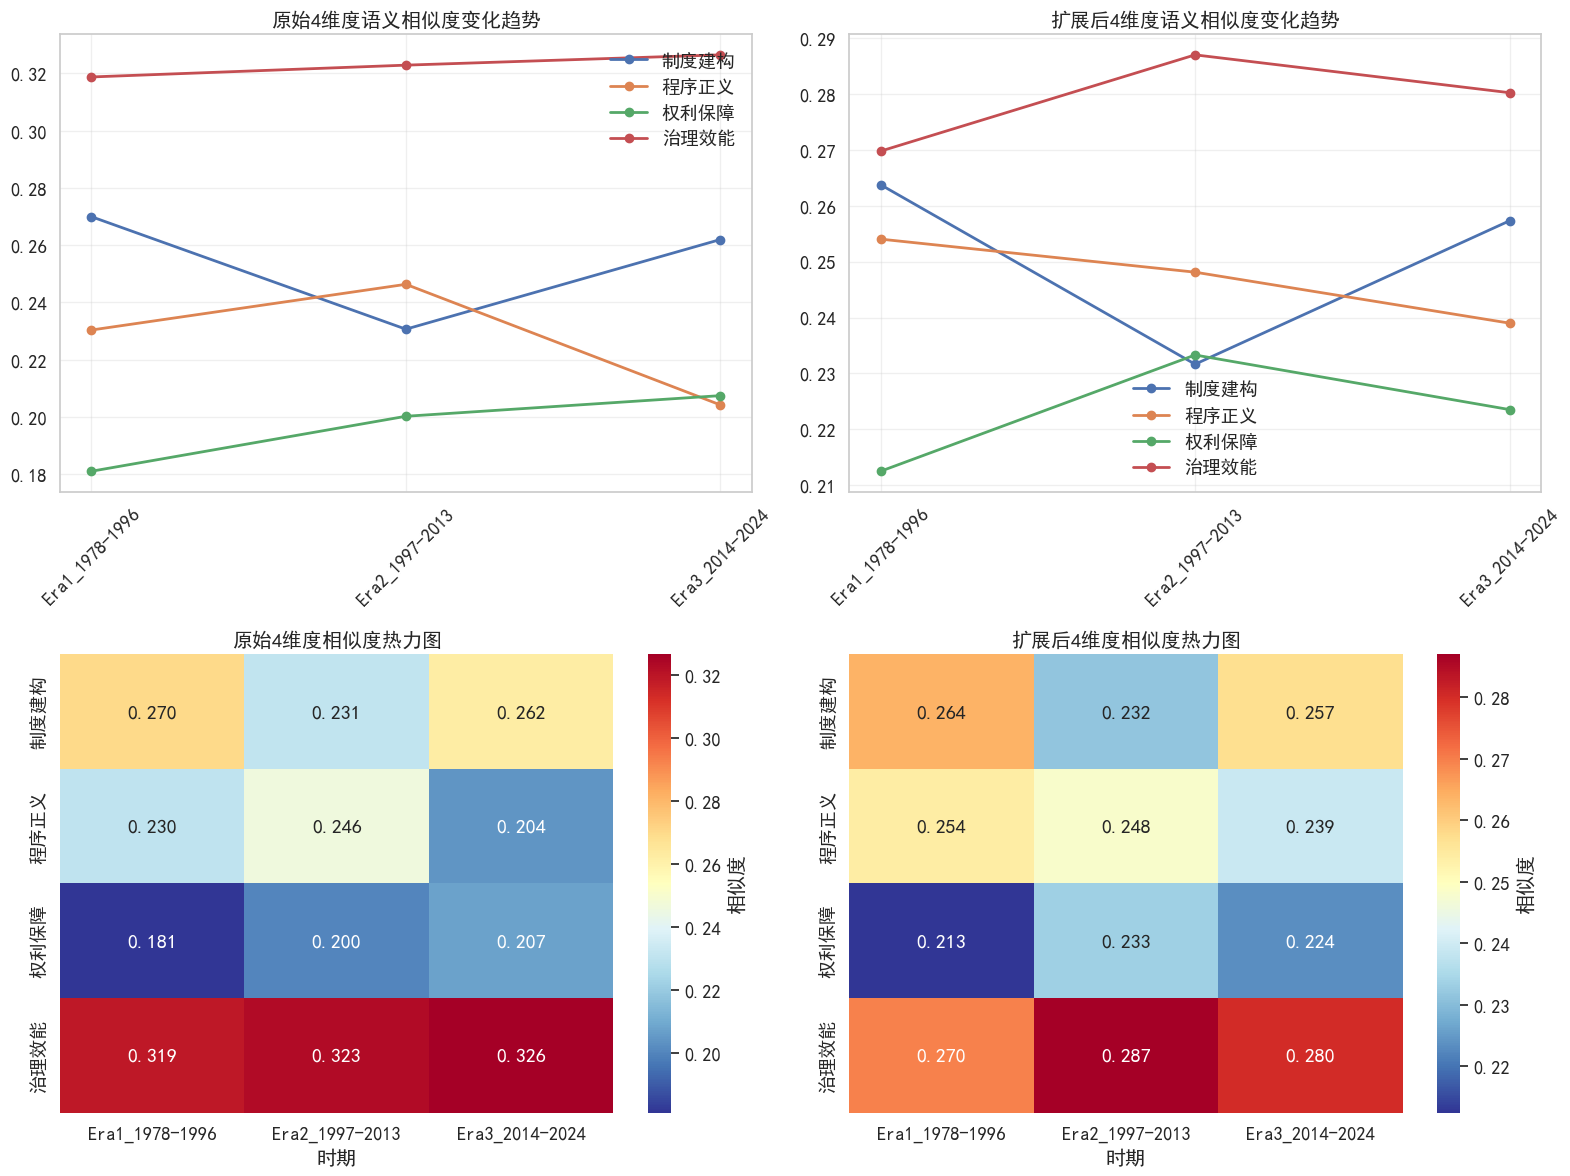


=== 各维度新增词汇示例 ===

制度建构 新增词汇 (59个):
  示例: 乡规民约, 规则, 社会公众, 公职人员, 规章制度, 法等, 建立健全, 规制, 法制化, 完备, 职责, 由此可见, 法学, 做法, 检察工作, 三是, 全国人大常委会法工委, 进一步, 有章可循, 宣传教育

程序正义 新增词汇 (62个):
  示例: 执法不严, 司法权, 严格执行, 二要, 普治, 重典, 根本大法, 卓泽渊, 依法处理, 法律化, 国法, 监督制约, 功过, 凡属, 刘武俊, 依法办案, 徐显明, 法家, 法律监督, 人权意识

权利保障 新增词汇 (51个):
  示例: 应有, 尊重人权, 践踏, 切实, 捍卫, 而言, 尊严, 行使, 公理, 权益, 本位, 正义, 安居乐业, 主体, 民事权利, 公正, 事实证明, 保障, 保障人权, 其本质

治理效能 新增词汇 (60个):
  示例: 体系化, 和谐社会, 整饬, 推进改革, 自律, 明察, 重要环节, 付子堂, 长治久安, 从己, 港治澳, 判断是非, 政法队伍, 严格执法, 立而, 公信, 治, 行为习惯, 遇事, 相得益彰


In [21]:

def expand_dimension_words_by_similarity(models, dimension_words, target_word="法治", 
                                       similarity_threshold=0.3, max_words_per_dim=50):
    """
    基于词向量相似度扩展维度词表（使用所有模型的平均相似度）
    
    Args:
        models: 词向量模型字典
        dimension_words: 初始维度词表
        target_word: 目标词（法治）
        similarity_threshold: 相似度阈值
        max_words_per_dim: 每个维度最大词数
        
    Returns:
        dict: 扩展后的维度词表
    """
    expanded_words = {dim: set(words) for dim, words in dimension_words.items()}
    
    print(f"使用所有 {len(models)} 个模型的平均相似度进行词表扩展")
    
    # 收集所有时期中与目标词相似的候选词
    candidate_words = set()
    
    for period, model in models.items():
        if target_word in model:
            similar_words = model.most_similar(target_word, topn=500)
            for word, similarity in similar_words:
                if similarity >= similarity_threshold:
                    candidate_words.add(word)
    
    print(f"候选词数量: {len(candidate_words)}")
    
    # 为每个候选词计算跨时期的平均相似度
    for word in candidate_words:
        # 计算与目标词的平均相似度
        target_similarities = []
        for period, model in models.items():
            if target_word in model and word in model:
                try:
                    sim = model.similarity(target_word, word)
                    target_similarities.append(sim)
                except:
                    pass
        
        if not target_similarities or np.mean(target_similarities) < similarity_threshold:
            continue
            
        # 计算该词与各维度核心词的平均相似度
        dim_similarities = {}
        
        for dim, core_words in dimension_words.items():
            all_dim_similarities = []
            
            for core_word in core_words:
                period_similarities = []
                for period, model in models.items():
                    if core_word in model and word in model:
                        try:
                            sim = model.similarity(word, core_word)
                            period_similarities.append(sim)
                        except:
                            pass
                
                if period_similarities:
                    all_dim_similarities.append(np.mean(period_similarities))
            
            if all_dim_similarities:
                dim_similarities[dim] = np.mean(all_dim_similarities)
        
        # 将词分配给相似度最高的维度
        if dim_similarities:
            best_dim = max(dim_similarities, key=dim_similarities.get)
            if (dim_similarities[best_dim] > similarity_threshold and 
                len(expanded_words[best_dim]) < max_words_per_dim):
                expanded_words[best_dim].add(word)
    
    # 转换回列表格式
    result = {dim: list(words) for dim, words in expanded_words.items()}
    
    print("\n扩展后的词表统计:")
    for dim, words in result.items():
        original_count = len(dimension_words[dim])
        expanded_count = len(words)
        new_words_count = expanded_count - original_count
        print(f"{dim}: {expanded_count} 个词 (原有 {original_count} + 新增 {new_words_count})")
    
    return result



# 运行词表扩展
print("\n=== 基于平均相似度扩展4维度词表 ===")
expanded_dimension_words_4d = expand_dimension_words_by_similarity(
    models, dimension_words_4d, target_word="法治", 
    similarity_threshold=0.25, max_words_per_dim=80
)

# 保存扩展后的词表
def save_expanded_dimension_words(expanded_words, output_path):
    """保存扩展后的维度词表"""
    output_path = Path(output_path)
    output_path.parent.mkdir(exist_ok=True)
    
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write("# 扩展后的法治4维度词表\n\n")
        
        for dim, words in expanded_words.items():
            f.write(f"# {dim} ({len(words)}个词)\n")
            f.write(f"{dim}:\n")
            
            # 每行写10个词
            for i in range(0, len(words), 10):
                line_words = words[i:i+10]
                f.write(" ".join(line_words) + "\n")
            f.write("\n")
    
    print(f"已保存扩展词表到: {output_path}")

# 保存扩展后的词表
save_expanded_dimension_words(expanded_dimension_words_4d, "expanded_dimension_words_4d.txt")

similarity_df_4d = calculate_dimension_similarities(
    models, dimension_words_4d,target_word="法治",normalize=True)
print("\n4维度相似度矩阵:")
print(similarity_df_4d)

# 计算扩展后词表的相似度并可视化
print("\n=== 扩展后词表相似度分析 ===")
expanded_similarity_df_4d = calculate_dimension_similarities(
    models, expanded_dimension_words_4d, target_word="法治", normalize=True
)

print("\n扩展后4维度相似度矩阵:")
print(expanded_similarity_df_4d)

# 对比原始和扩展后的相似度
if not expanded_similarity_df_4d.empty:
    # 绘制对比图
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 原始词表趋势图
    axes[0, 0].set_title("原始4维度语义相似度变化趋势")
    for dim in similarity_df_4d.columns[1:]:
        axes[0, 0].plot(similarity_df_4d['时期'], similarity_df_4d[dim], 
                       marker='o', linewidth=2, label=dim)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 扩展后词表趋势图
    axes[0, 1].set_title("扩展后4维度语义相似度变化趋势")
    for dim in expanded_similarity_df_4d.columns[1:]:
        axes[0, 1].plot(expanded_similarity_df_4d['时期'], expanded_similarity_df_4d[dim], 
                       marker='o', linewidth=2, label=dim)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 原始词表热力图
    original_heatmap_data = similarity_df_4d.set_index('时期').T
    sns.heatmap(original_heatmap_data, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                ax=axes[1, 0], cbar_kws={'label': '相似度'})
    axes[1, 0].set_title("原始4维度相似度热力图")
    
    # 扩展后词表热力图
    expanded_heatmap_data = expanded_similarity_df_4d.set_index('时期').T
    sns.heatmap(expanded_heatmap_data, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                ax=axes[1, 1], cbar_kws={'label': '相似度'})
    axes[1, 1].set_title("扩展后4维度相似度热力图")
    
    plt.tight_layout()
    plt.show()
    
    # 显示新增词汇示例
    print("\n=== 各维度新增词汇示例 ===")
    for dim in dimension_words_4d.keys():
        original_words = set(dimension_words_4d[dim])
        expanded_words = set(expanded_dimension_words_4d[dim])
        new_words = expanded_words - original_words
        
        print(f"\n{dim} 新增词汇 ({len(new_words)}个):")
        if new_words:
            # 显示前20个新增词汇
            sample_words = list(new_words)[:20]
            print(f"  示例: {', '.join(sample_words)}")
        else:
            print("  无新增词汇")

